In [1]:
import pandas as pd

passengers = pd.read_csv("Data/train.csv")
passengers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
from sklearn.model_selection import train_test_split

X = passengers.drop(columns=["Survived"])
Y = passengers["Survived"]

# Splitting the dataset to train and test sets
x, x_test, y, y_test = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state=42)

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


# A custom transformer to make all the extra features
class FeatureEngineering(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        # Bins and labels to create the AgeGroup
        self.age_bins = [0, 3, 12, 20, 60, 200]
        self.age_labels = ["toddler", "child", "teen", "adult", "senior"]
        # Initializing variables to store the wealth quantiles and grouping them
        self.q25 = 0
        self.q50 = 0
        self.q75 = 0
        self.fare_bins = []
        self.fare_labels = ["VeryLow", "Low", "Medium", "High"]
                
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Extracting the title
        X["Title"] = X["Name"].apply(lambda x: x.split(", ")[1].split(".")[0])
        # Grouping the titles
        X['Title'] = X['Title'].apply(lambda x: x if x in ["Mr", "Miss", "Mrs", "Master"] else "Rare")
        X['IsTitleRare'] = X['Title'].apply(lambda x: 1 if x=="Rare" else 0)
        
        # Defining a new feature - age group
        X['Age'].fillna(X['Age'].median(), inplace=True)
        X["AgeGroup"] = pd.cut(X["Age"], bins=self.age_bins, labels=self.age_labels)
        
        # Person + family members on board
        X["FamilySize"] = X["SibSp"] + X["Parch"] + 1
        
        # Calculate adjusted fare (ticket price per person)
        X['Fare'].fillna(X['Fare'].median(), inplace=True)
        X["TicketCount"] = X["Ticket"].map(X["Ticket"].value_counts())
        X["AdjustedFare"] = round(X["Fare"] / X["TicketCount"], 4)
        
        # Replacing Fares = 0 with median and adding log fare
        X['AdjustedFare'].replace(0, X['AdjustedFare'].median(), inplace=True)
        X['LogFare'] = np.log(X['AdjustedFare'])
        
        # Extracting wealth from fare
        self.q25, self.q50, self.q75 = list(X['AdjustedFare'].quantile([.25, .5, .75]))
        self.fare_bins = [0, self.q25, self.q50, self.q75, X['AdjustedFare'].max()]
        X["Wealth"] = pd.cut(X["AdjustedFare"], bins=self.fare_bins, labels=self.fare_labels)
        
        # Extracting deck of residance for each passanger
        X["Deck"] = X["Cabin"].str[0]
        X["Deck"].fillna("N/A", inplace=True)
        
        # Check if passenger has cabin
        X['HasCabin'] = X['Deck'].apply(lambda x: 0 if x=="N/A" else 1)
        
        # Check if passenger is traveling solo
        X['IsAlone'] = X['FamilySize'].apply(lambda x: 1 if x==1 else 0)

        
        return X

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


num_features = ['Age', 'LogFare', 'FamilySize']
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'AgeGroup', 'Wealth']
drop_features = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# The all-in-one preprocessing pipeline
preprocessing = Pipeline([
    ('feature_engineering', FeatureEngineering()),
    ('preprocessor', ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features),
        ('dropper', 'drop', drop_features)
    ]))
])

In [5]:
# Preprocessed data
x_preproc = preprocessing.fit_transform(x)

In [6]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from aquarel import load_theme
import json

# Using the Aquarel library with some customization for the plots
theme = load_theme("boxy_dark")
theme.set_color(figure_background_color="#181818",
                plot_background_color="#242424")
theme.set_font(family="monospace", size=9)
theme.apply_transforms()
theme.apply()

# Dictionary to store all the cross validation and training data for the models
history = {}

def plot_learning_curves(models_list: list, x, y, cv=5, size:int=10, n_columns:int=3):
    n_models = len(models_list)
    # Calculate the minimum number of rows to fit the plotting grid
    n_rows = (n_models + n_columns - 1) // n_columns

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(15, n_rows * 5))
    # Converting the axs objects to a n by m shape, so individual axs would be iterable
    axs = np.array(axs).reshape(n_rows, n_columns)

    for i, (model, model_name) in enumerate(models_list):
        
        print(f"Working on {model_name}")
        # Evaluating the models performance for multiple cuts of dataset with different sizes
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=model,
            X=x,
            y=y,
            train_sizes=np.linspace(0.1, 1.0, size),
            cv=cv,
            scoring='accuracy'
        );
        
        # Adding the models performance data into a dictionary
        history.update({model_name:[train_sizes.tolist(), train_scores.tolist(), test_scores.tolist()]})

        # One-liner to calculate divizable and remainder, corresponding to row and column of the respected ax
        row, col = divmod(i, n_columns)
        ax = axs[row, col]
        ax.plot(train_sizes, train_scores.mean(axis=1), label="Train", marker="o")
        ax.plot(train_sizes, test_scores.mean(axis=1), label="Valid", marker="s")
        ax.set_title(model_name)
        ax.legend()
    
    fig.supxlabel("Samples in training set")
    fig.supylabel("Accuracy")

    # Remove the remainder empty subplots
    for i in range(n_models, n_rows * n_columns):
        fig.delaxes(axs.flatten()[i])
    
    # Storing all the training and validation performance as a json file    
    with open('history.json', 'w') as file:
        json.dump(history, file)

    plt.tight_layout()
    plt.show()

In [7]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier


voting_clf = VotingClassifier(
    estimators=[
        ('svc', SVC()),
        ('rfc', RandomForestClassifier(max_features=5, max_depth=5)),
        ('lr', LogisticRegression()),
        ('gbc', GradientBoostingClassifier())
    ]
)

# List of models be plotted and evaluated
models_list = [
    (LogisticRegression(), "LogisticRegression"),
    (LogisticRegressionCV(), "LogisticRegressionCV"),
    (SGDClassifier(), "SGDClassifier"),
    (SVC(), "SVC"),
    (DecisionTreeClassifier(), "DecisionTreeClassifier"),
    (RandomForestClassifier(), "RandomForestClassifier"),
    (voting_clf, "VotingClassifier"),
    (GradientBoostingClassifier(), "GradientBoostingClassifier")
]

Working on LogisticRegression
Working on LogisticRegressionCV
Working on SGDClassifier
Working on SVC
Working on DecisionTreeClassifier
Working on RandomForestClassifier
Working on VotingClassifier
Working on GradientBoostingClassifier


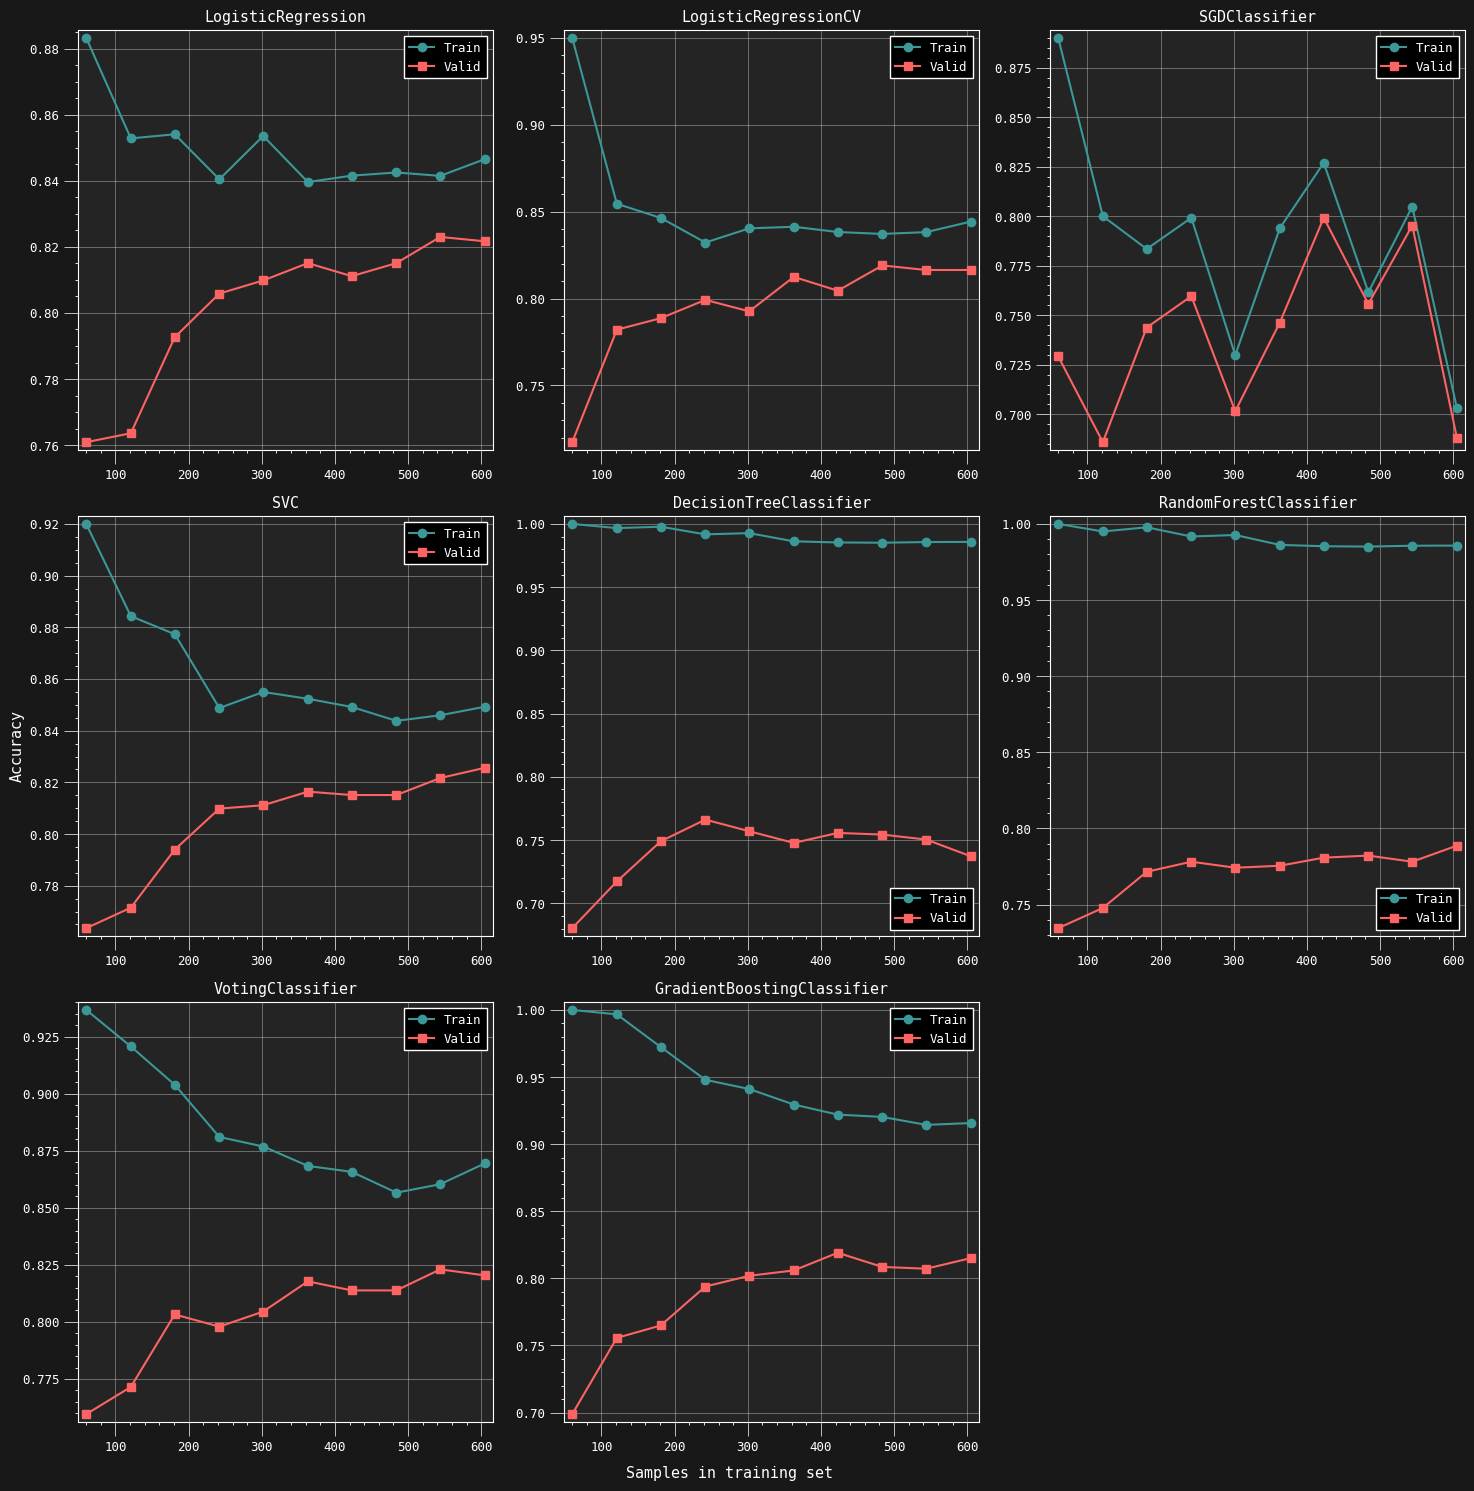

In [8]:
plot_learning_curves(models_list=models_list,
                     x=x_preproc,
                     y=y,
                     size=10);

In [9]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint


rfc_pipeline = make_pipeline(preprocessing, RandomForestClassifier())

param_dist_rfc = {
    'randomforestclassifier__max_depth': [2, 4, 6, 10, 20],
    'randomforestclassifier__max_leaf_nodes': [2, 4, 6, 10, 20],
    'randomforestclassifier__max_features': [2, 4, 6, 10, 20],
    'randomforestclassifier__n_estimators': [50, 100, 200],
}

rfc_search = GridSearchCV(
    estimator=rfc_pipeline,
    param_grid=param_dist_rfc,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

rfc_search.fit(x, y)
rfc_search.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__max_features': 6,
 'randomforestclassifier__max_leaf_nodes': 20,
 'randomforestclassifier__n_estimators': 50}

In [10]:
lr_pipeline = make_pipeline(preprocessing, LogisticRegression())

param_dist_lr = {
    'logisticregression__C': randint(low=1, high=100),
}

lr_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_dist_lr,
    n_iter=100,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

lr_search.fit(x, y)
lr_search.best_params_

{'logisticregression__C': 1}

In [11]:
gbc_pipeline = make_pipeline(preprocessing, GradientBoostingClassifier())

param_dist_gbc = {
    'gradientboostingclassifier__max_depth': [2, 4, 6, 10, 20],
    'gradientboostingclassifier__max_features': [2, 4, 6, 10, 20],
    'gradientboostingclassifier__n_estimators': [10, 50, 100, 200],
}

gbc_search = GridSearchCV(
    estimator=gbc_pipeline,
    param_grid=param_dist_gbc,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

gbc_search.fit(x, y)
gbc_search.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__max_features': 10,
 'gradientboostingclassifier__n_estimators': 50}

In [12]:
svc_pipeline = make_pipeline(preprocessing, SVC())

param_dist_svc = {
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__C': [1, 5, 10, 20],
    'svc__degree': [2, 3, 4, 5],
}

svc_search = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=param_dist_svc,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

svc_search.fit(x, y)
svc_search.best_params_

{'svc__C': 5, 'svc__degree': 2, 'svc__kernel': 'poly'}

Working on SVC-FineTune
Working on RandomForestClassifier-FineTune
Working on VotingClassifier-FineTune
Working on GradientBoostingClassifier-FineTune


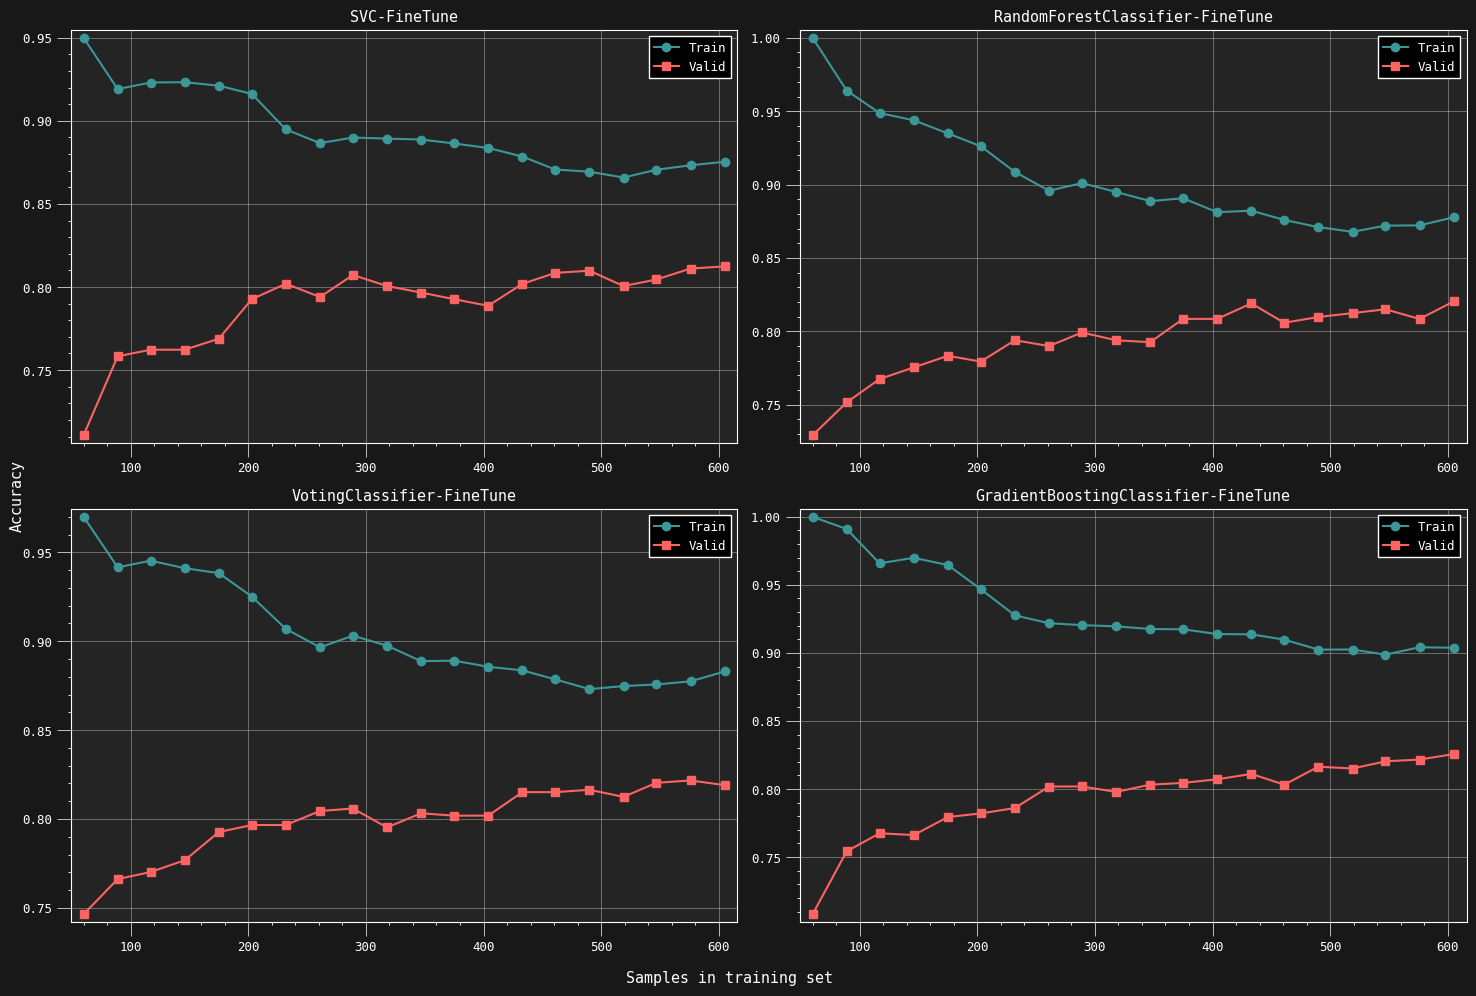

In [13]:
# Remove prefixes from best_params_
svc_best_params = {k.split("__")[-1]: v for k, v in svc_search.best_params_.items()}
rfc_best_params = {k.split("__")[-1]: v for k, v in rfc_search.best_params_.items()}
lr_best_params = {k.split("__")[-1]: v for k, v in lr_search.best_params_.items()}
gbc_best_params = {k.split("__")[-1]: v for k, v in gbc_search.best_params_.items()}

# Defining the fine-tunned models
svc_model = SVC(**svc_best_params)
rfc_model = RandomForestClassifier(**rfc_best_params)
lr_model = LogisticRegression(**lr_best_params)
gbc_model = GradientBoostingClassifier(**gbc_best_params)

voting_clf_model = VotingClassifier(
    estimators=[
        ('svc', svc_model),
        ('rfc', rfc_model),
        ('lr', lr_model),
        ('gbc', gbc_model)
    ]
)

tunned_models_list = [
    (svc_model, "SVC-FineTune"),
    (rfc_model, "RandomForestClassifier-FineTune"),
    (voting_clf_model, "VotingClassifier-FineTune"),
    (gbc_model, "GradientBoostingClassifier-FineTune"),
]

plot_learning_curves(tunned_models_list,
                     x=x_preproc,
                     y=y,
                     size=20,
                     n_columns=2)

In [14]:
svc_estimator = make_pipeline(preprocessing, svc_model)
rfc_estimator = make_pipeline(preprocessing, rfc_model)
voting_clf_estimator = make_pipeline(preprocessing, voting_clf_model)
gbc_estimator = make_pipeline(preprocessing, gbc_model)

svc_estimator.fit(x,y)
rfc_estimator.fit(x,y)
voting_clf_estimator.fit(x,y)
gbc_estimator.fit(x,y);

In [15]:
from sklearn.model_selection import cross_val_score

svc_cv_score = cross_val_score(svc_estimator, x, y, cv=5)
rfc_cv_score = cross_val_score(rfc_estimator, x, y, cv=5)
voting_clf_cv_score = cross_val_score(voting_clf_estimator, x, y, cv=5)
gbc_cv_score = cross_val_score(gbc_estimator, x, y, cv=5)

print(f"SVC Training Set Cross Validation Score: {round(svc_cv_score.mean()*100, 4)} %")
print(f"Random Forest Training Set Cross Validation Score: {round(rfc_cv_score.mean()*100, 4)} %")
print(f"Voting Training Set Cross Validation Score: {round(voting_clf_cv_score.mean()*100, 4)} %")
print(f"Gradient Boosting Training Set Cross Validation Score: {round(gbc_cv_score.mean()*100, 4)} %")

SVC Training Set Cross Validation Score: 81.6382 %
Random Forest Training Set Cross Validation Score: 82.1706 %
Voting Training Set Cross Validation Score: 81.9022 %
Gradient Boosting Training Set Cross Validation Score: 82.5645 %


In [16]:
print(f"SVC Test Set Score: {round(svc_estimator.score(x_test, y_test)*100, 4)} %")
print(f"Random Forest Test Set Score: {round(rfc_estimator.score(x_test, y_test)*100, 4)} %")
print(f"Voting Test Set Score: {round(voting_clf_estimator.score(x_test, y_test)*100, 4)} %")
print(f"Gradient Boosting Test Set Score: {round(gbc_estimator.score(x_test, y_test)*100, 4)} %")

SVC Test Set Score: 77.6119 %
Random Forest Test Set Score: 81.3433 %
Voting Test Set Score: 81.3433 %
Gradient Boosting Test Set Score: 82.0896 %
